# Student Performance Prediction

## Objective
Predict student performance (Final Grade `G3`) using demographic and school-related data. 

This notebook covers:
1. **Pre-processing and EDA**: Understanding the data structure and quality.
2. **Feature Engineering**: Creating relevant features from existing ones.
3. **Data Visualization**: Exploring distributions and relationships.
4. **Class Balancing**: Handling imbalanced data for classification tasks.
5. **Modeling**: 
    - **Regression**: Predicting the exact grade (0-20).
    - **Classification**: Predicting student Pass/Fail status.
6. **Evaluation**: Assessing model performance.

**Note on Target Variable**:
- We target `G3` (Final Grade).
- We explore two prediction scenarios:
    1. **Early Prediction**: Predicting G3 *without* using G1 and G2 (grades from 1st/2nd period). This is harder but more useful for early intervention.
    2. **Full Information**: Using G1 and G2. This typically yields high accuracy but is less actionable.

In [19]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

# Set visual style
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

In [20]:
# 2. Load Data
# Ensure the csv file is in the same directory
try:
    df = pd.read_csv('student_performance.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'student_performance.csv' not found.")

df.head()

Dataset loaded successfully.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


# 3. Pre-processing and EDA

In [21]:
# Check dataset info
print(df.info())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum().sum())

<class 'pandas.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      649 non-null    str  
 1   sex         649 non-null    str  
 2   age         649 non-null    int64
 3   address     649 non-null    str  
 4   famsize     649 non-null    str  
 5   Pstatus     649 non-null    str  
 6   Medu        649 non-null    int64
 7   Fedu        649 non-null    int64
 8   Mjob        649 non-null    str  
 9   Fjob        649 non-null    str  
 10  reason      649 non-null    str  
 11  guardian    649 non-null    str  
 12  traveltime  649 non-null    int64
 13  studytime   649 non-null    int64
 14  failures    649 non-null    int64
 15  schoolsup   649 non-null    str  
 16  famsup      649 non-null    str  
 17  paid        649 non-null    str  
 18  activities  649 non-null    str  
 19  nursery     649 non-null    str  
 20  higher      649 non-null    str  
 21  inte

In [22]:
# Statistical description
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


# 4. Data Visualization

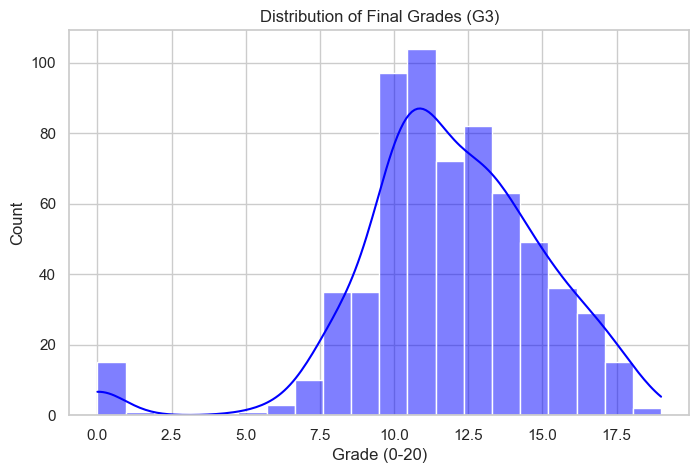

In [23]:
# Target Variable Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['G3'], bins=20, kde=True, color='blue')
plt.title('Distribution of Final Grades (G3)')
plt.xlabel('Grade (0-20)')
plt.show()

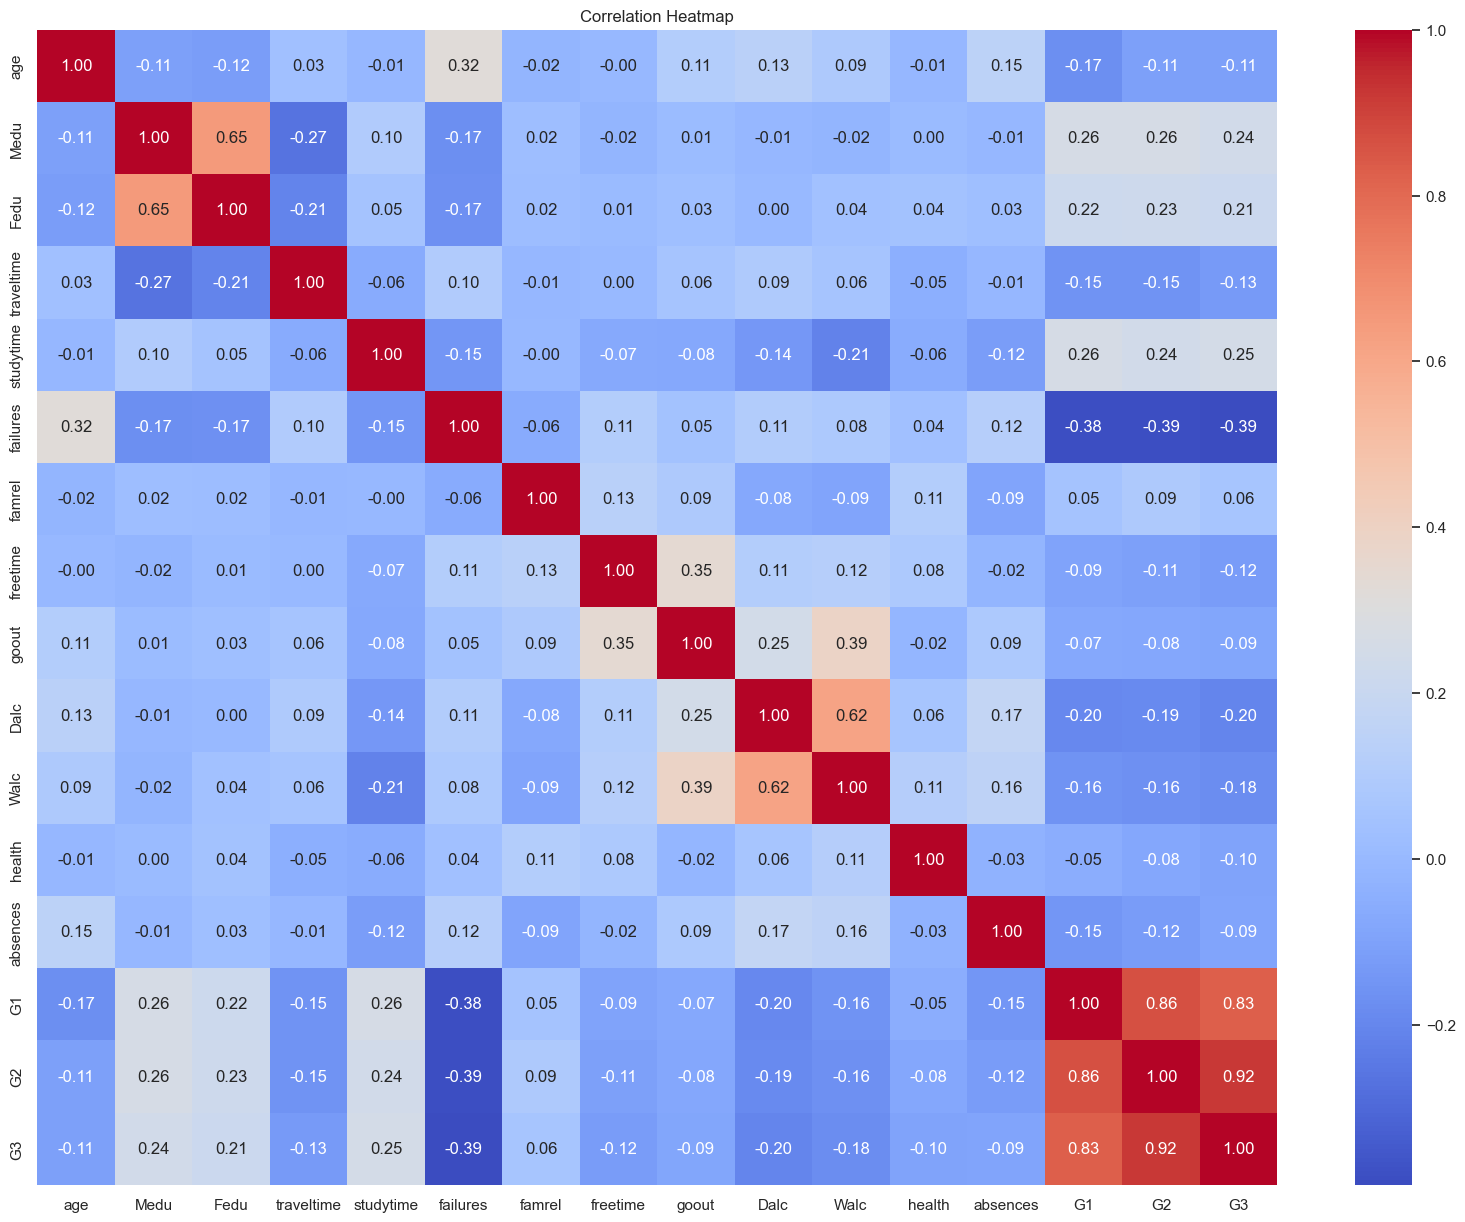

In [24]:
# Correlation Matrix
plt.figure(figsize=(20, 15))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Observation**: `G1` and `G2` are highly correlated with `G3`. This confirms that previous grades are the strongest predictors. Other factors like `Medu` (Mother's Education) and `studytime` show moderate positive correlation, while `failures` shows negative correlation.

C:\Users\PC\AppData\Local\Temp\ipykernel_26856\1288581002.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dalc', y='G3', data=df, ax=axes[0], palette='viridis')
C:\Users\PC\AppData\Local\Temp\ipykernel_26856\1288581002.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Walc', y='G3', data=df, ax=axes[1], palette='viridis')


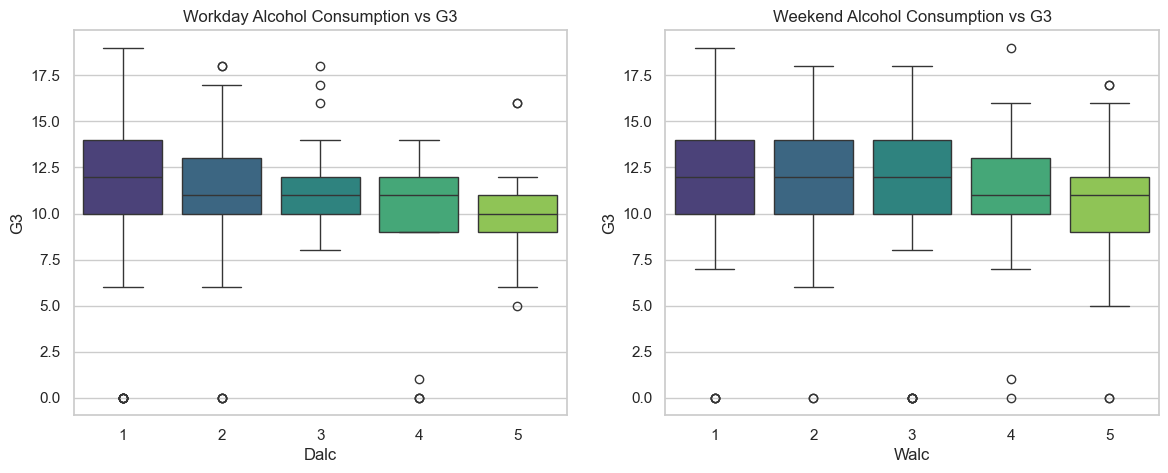

In [25]:
# Impact of Alcohol Consumption on Grades
# Dalc: Workday alcohol, Walc: Weekend alcohol

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='Dalc', y='G3', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Workday Alcohol Consumption vs G3')

sns.boxplot(x='Walc', y='G3', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Weekend Alcohol Consumption vs G3')

plt.show()

# 5. Feature Engineering / Selection

In [26]:
# Create new aggregate features

# 1. Total Alcohol Consumption
df['Total_Alc'] = df['Dalc'] + df['Walc']

# 2. Parent Average Education
df['Parent_Edu'] = (df['Medu'] + df['Fedu']) / 2

# 3. Family Support + School Support (Total Support)
# Convert yes/no to 1/0 for addition
df['schoolsup_bin'] = df['schoolsup'].map({'yes': 1, 'no': 0})
df['famsup_bin'] = df['famsup'].map({'yes': 1, 'no': 0})
df['Total_Support'] = df['schoolsup_bin'] + df['famsup_bin']

# Drop intermediate columns if desired (keeping them for now)

# 4. Target for Classification Task
# Define Pass/Fail. Usually >= 10 is Pass in the Portuguese system.
df['passed'] = df['G3'].apply(lambda x: 1 if x >= 10 else 0)

print("New Features Added: Total_Alc, Parent_Edu, Total_Support, passed")
df[['Total_Alc', 'Parent_Edu', 'Total_Support', 'passed']].head()

New Features Added: Total_Alc, Parent_Edu, Total_Support, passed


,Total_Alc,Parent_Edu,Total_Support,passed
0,2,4.0,1,1
1,2,1.0,1,1
2,5,1.0,1,1
3,2,3.0,1,1
4,3,3.0,1,1


In [27]:
# Encoding Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical Columns: {list(categorical_cols)}")

# We will use Label Encoding for binary/ordinal and One-Hot (get_dummies) for nominal
# For simplicity in this demo, we use get_dummies for all nominal, or LabelEncoder for binary.
le = LabelEncoder()

# Binary columns
binary_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# Nominal columns -> One Hot Encoding
nominal_cols = ['Mjob', 'Fjob', 'reason', 'guardian']
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

print("Encoding Complete. Shape:", df.shape)

Categorical Columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Encoding Complete. Shape: (649, 48)


C:\Users\PC\AppData\Local\Temp\ipykernel_26856\843710794.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include=['object']).columns


# 6. Class Balancing (For Classification Task)

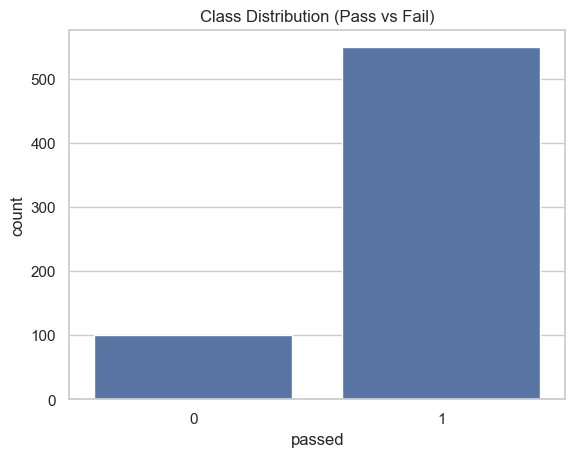

Class Counts:
 passed
1    549
0    100
Name: count, dtype: int64


In [28]:
# Check class distribution
sns.countplot(x='passed', data=df)
plt.title("Class Distribution (Pass vs Fail)")
plt.show()

pass_count = df['passed'].value_counts()
print("Class Counts:\n", pass_count)

# If imbalance is severe, we will use SMOTE during the model training phase.

# 7. Normalization and Data Splitting
We prepare two sets of data:
- **Set A (Early Prediction)**: Drop `G1`, `G2`, `G3`, `passed` (Target).
- **Set B (Full Info - Baseline)**: Include `G1`, `G2`.

In [29]:
# Define Features (X) and Target (y)
# Target for Regression
y_reg = df['G3']
# Target for Classification
y_class = df['passed']

# 1. Early Prediction Features (No G1, G2)
X_early = df.drop(['G1', 'G2', 'G3', 'passed', 'schoolsup_bin', 'famsup_bin'], axis=1) # Dropping derivatives of G3/G2/G1 if any (none exist except passed)

# 2. Full Features (With G1, G2)
X_full = df.drop(['G3', 'passed', 'schoolsup_bin', 'famsup_bin'], axis=1)

print("X_early shape:", X_early.shape)
print("X_full shape:", X_full.shape)

X_early shape: (649, 42)
X_full shape: (649, 44)


In [30]:
# Split Data (Using Early Set for primary demonstration)
X_train, X_test, y_train, y_test = train_test_split(X_early, y_reg, test_size=0.2, random_state=42)

# Normalization (Tree models don't strictly need it, but good for Neural Nets or KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train/Test Split Complete.")

Train/Test Split Complete.


# 8. Model Training - Regression (Early Prediction)

In [31]:
# Initialize Models
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
lr_reg = LinearRegression()

# Train Random Forest
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Train XGBoost
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

# Train Linear Regression (Baseline)
lr_reg.fit(X_train_scaled, y_train)
y_pred_lr = lr_reg.predict(X_test_scaled)

# 9. Model Evaluation

In [32]:
def evaluate_regression(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}\n")
    return r2

evaluate_regression(y_test, y_pred_rf, "Random Forest (Early)")
evaluate_regression(y_test, y_pred_xgb, "XGBoost (Early)")
evaluate_regression(y_test, y_pred_lr, "Linear Regression (Early)")

--- Random Forest (Early) ---
MSE: 8.28
MAE: 2.08
R2 Score: 0.15

--- XGBoost (Early) ---
MSE: 9.41
MAE: 2.22
R2 Score: 0.04

--- Linear Regression (Early) ---
MSE: 8.19
MAE: 2.16
R2 Score: 0.16



0.16016991964318306

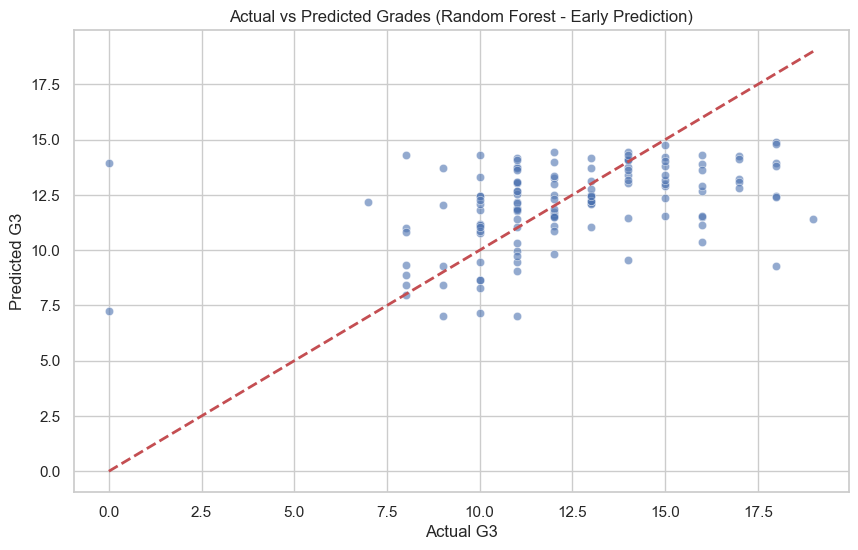

In [33]:
# Results Visualization: Actual vs Predicted (Random Forest)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual G3')
plt.ylabel('Predicted G3')
plt.title('Actual vs Predicted Grades (Random Forest - Early Prediction)')
plt.show()

# 10. Classification Task with Class Balancing
Predicting if a student Passes (G3 >= 10) or Fails.

Original Class Distribution: {1: 434, 0: 85}
Resampled Class Distribution: {1: 434, 0: 434}

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.33      0.38        15
           1       0.92      0.95      0.93       115

    accuracy                           0.88       130
   macro avg       0.69      0.64      0.66       130
weighted avg       0.86      0.88      0.87       130

Confusion Matrix:
 [[  5  10]
 [  6 109]]


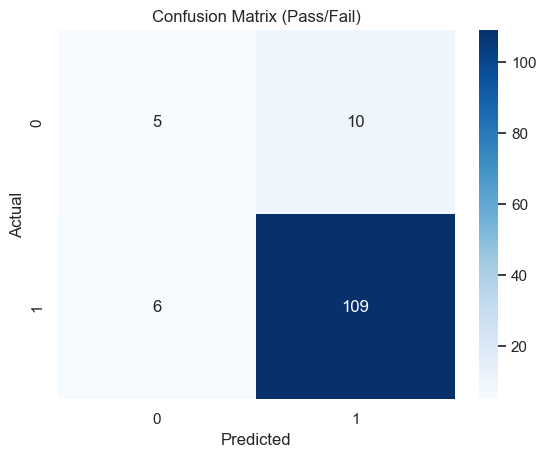

In [34]:
# Split Data for Classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_early, y_class, test_size=0.2, random_state=42)

# Apply SMOTE (Synthetic Minority Over-sampling Technique)
# This balances the training data by creating synthetic examples of the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_c, y_train_c)

print("Original Class Distribution:", y_train_c.value_counts().to_dict())
print("Resampled Class Distribution:", y_train_resampled.value_counts().to_dict())

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_class = rf_clf.predict(X_test_c)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test_c, y_pred_class))

# Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_test_c, y_pred_class), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Pass/Fail)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 11. Feature Importance
What factors matter most? (From the Random Forest Model)

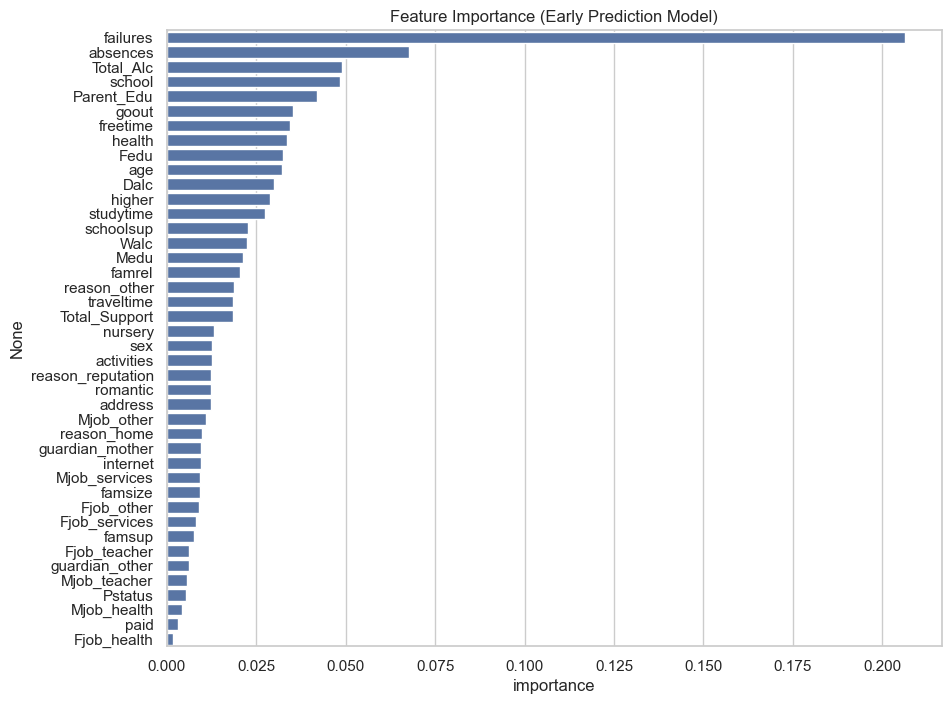

In [35]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance (Early Prediction Model)')
plt.show()

# 12. Saving the Model
We save the 'Early Prediction' Random Forest model as it is identified as the most useful.

In [36]:
joblib.dump(rf_reg, 'student_performance_rf_model.pkl')
print("Model saved as 'student_performance_rf_model.pkl'")

Model saved as 'student_performance_rf_model.pkl'
